### NLP exploration of Find it Fix It requests to the City of Seattle (from a FOI request)

In [6]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from collections import Counter

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':30,
                              'axes.titlesize':30,
                              'axes.labelsize':30})
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.text import Text
from nltk.probability import FreqDist

import gensim
from gensim import corpora


In [7]:
#path for FIFI FOI request data (already prepped for NLP)
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/FIFI_nlp_data.pkl'

In [8]:
#read in pkl file containing 
data = pd.read_pickle(path)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)
data.head(1)

Service_Request_Number        Created_Date                         Location                                   Location_Details      Description License_Number State Vehicle_Make Vehicle_Color  Time_parked Photo FIFI_category Location_Details.1 Property_damage? Current_Issue Type_of_animal On_private_property? Graffiti_location Location_and_Description Obscene/Racial/Hateful? Street/Intersection Where? Type_of_item? Veg_location Vegetation_Safety_Issue Parking_Violation_Concerning License_Plate_Number Location_details  7_digit_number_on_pole Issue        date  year  month  day day_of_week  hour                                          date_bin zip neighborhood      entry_clean            desc_nltk                                    POS
0            13-00036779 2013-05-09 20:32:33  5208 BEACON AVE S, SEATTLE, WA   5200 Beacon Ave S Seattle, WA 98108; XY: 12775...  Ford light blue        AHZ9829   NaN         Ford          Blue  Over 3 Days   NaN  Abnd_Vehicle                NaN              NaN           NaN            NaN                  NaN               NaN                      NaN                     NaN                 NaN    NaN           NaN          NaN                     NaN                          NaN                  NaN              NaN                     NaN   NaN  2013-05-09  2013      5    9    Thursday    20  (1.3680047394092564e+18, 1.3729967948195128e+18]  WA           WA  ford light blue  [ford, light, blue]  [(ford, NN), (light, NN), (blue, NN)]

In [9]:
#select zips that have great than 999 entries
zip_counts = data['zip'].value_counts()
zip_counts_5000 = zip_counts[zip_counts > 4999].index.values
data_filtered = data[data['zip'].isin(zip_counts_5000)]
print('Combined data final zips: ', '\n', data_filtered['zip'].value_counts(), '\n')

#select FIFI categories that have great than 999 entries
cat_counts = data_filtered['FIFI_category'].value_counts()
cat_counts_5000 = cat_counts[cat_counts > 4999].index.values
data_filtered = data_filtered[data_filtered['FIFI_category'].isin(cat_counts_5000)]
print('Combined data final FIFI categories: ', '\n', data_filtered['FIFI_category'].value_counts(), '\n') 

print('Final data size: \n', data_filtered.shape)

Combined data final zips:  
 WA       30119
98103    17337
98107    15741
98144    12955
98105    11483
98118    11342
98108    11009
98122    10294
98115     8438
98117     8033
98109     7962
98102     7426
98133     7292
98125     7274
98104     6834
98106     6743
98112     5886
98119     5800
98199     5304
Name: zip, dtype: int64 

Combined data final FIFI categories:  
 Other              45761
Needles/Dumping    37529
Parking            27847
Abnd_Vehicle       27561
Grafitti           23560
Pothole            19262
Sign/Signal         9293
Streetlight         5811
Name: FIFI_category, dtype: int64 

Final data size: 
 (196624, 42)


In [75]:
#create list of FIFI cats ordered by request count to use for ordering of x axis on graphs
cat_order = data_filtered['FIFI_category'].value_counts().index.values

#create list of neighborhoods ordered by request count to use for ordering of x axis on graphs
neigh_order = data_filtered['neighborhood'].value_counts().index.values

### Unsupervised sentiment analysis

In [76]:
#use sentiment.vader to get polarity score of each entry
#use original text entry (sentiment vader takes into account puntuation etc)
sid = SentimentIntensityAnalyzer()

data_filtered['polarity'] = [sid.polarity_scores(row)['compound'] for row in data_filtered['Description']]

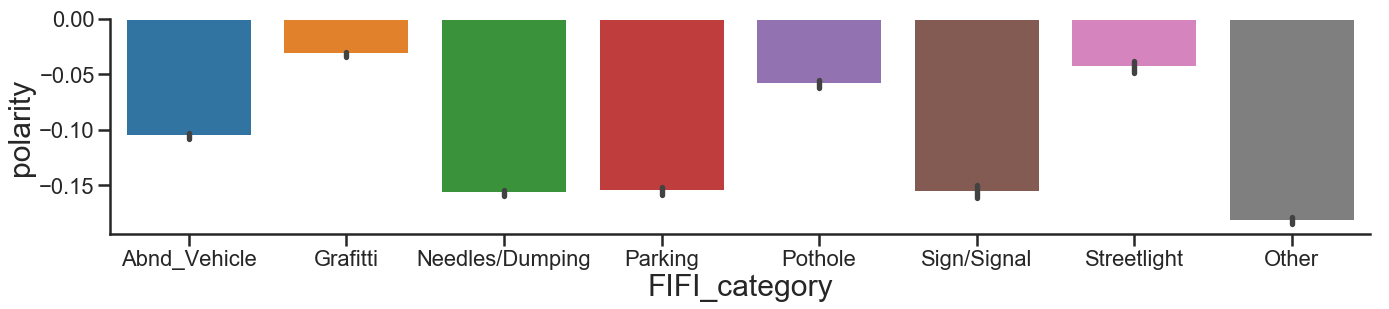

In [77]:
sns.catplot(x='FIFI_category', y='polarity', data=data_filtered, kind='bar', height=5, aspect=4)

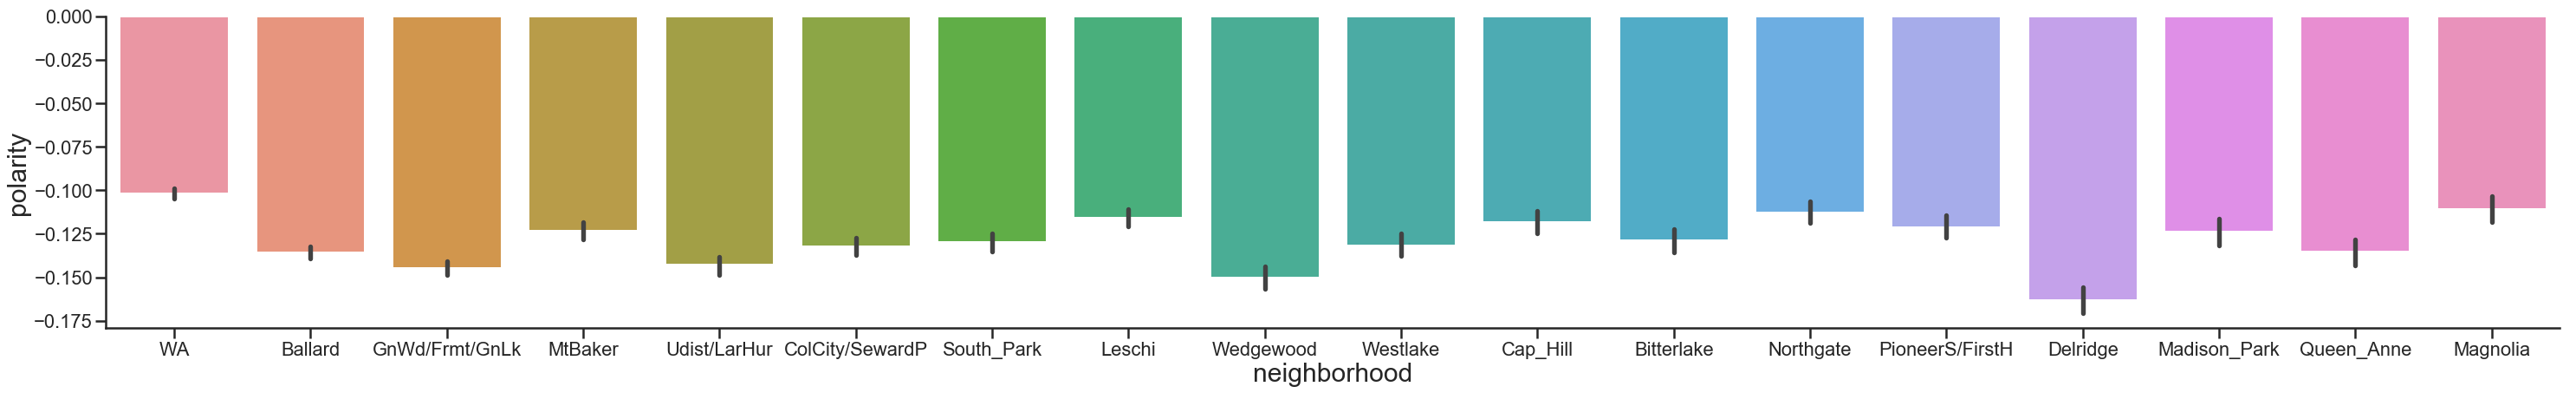

In [78]:
sns.catplot(x='neighborhood', y='polarity', data=data_filtered, kind='bar', height=7, aspect=6, order=neigh_order)

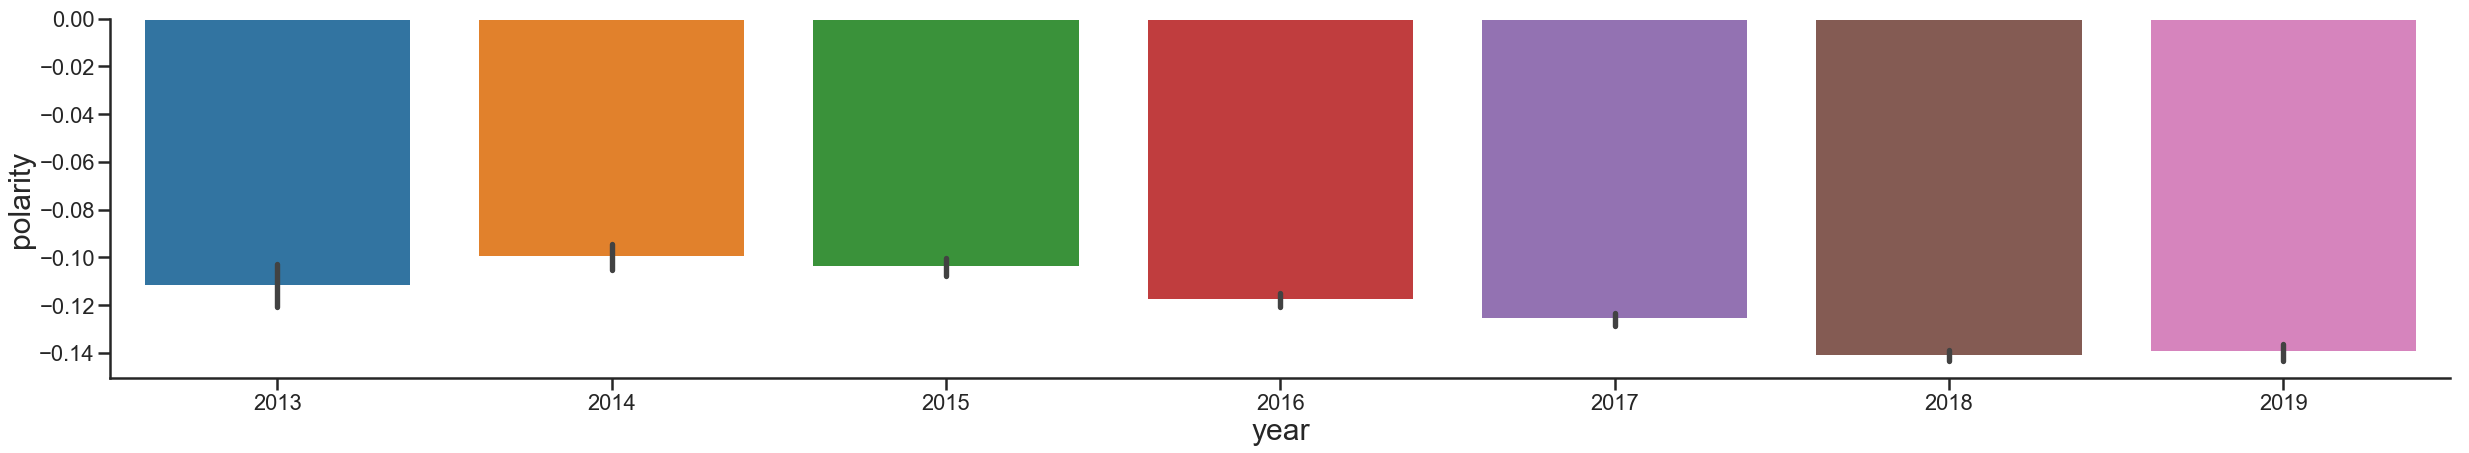

In [79]:
sns.catplot(x='year', y='polarity', data=data_filtered, kind='bar', height=7, aspect=5)

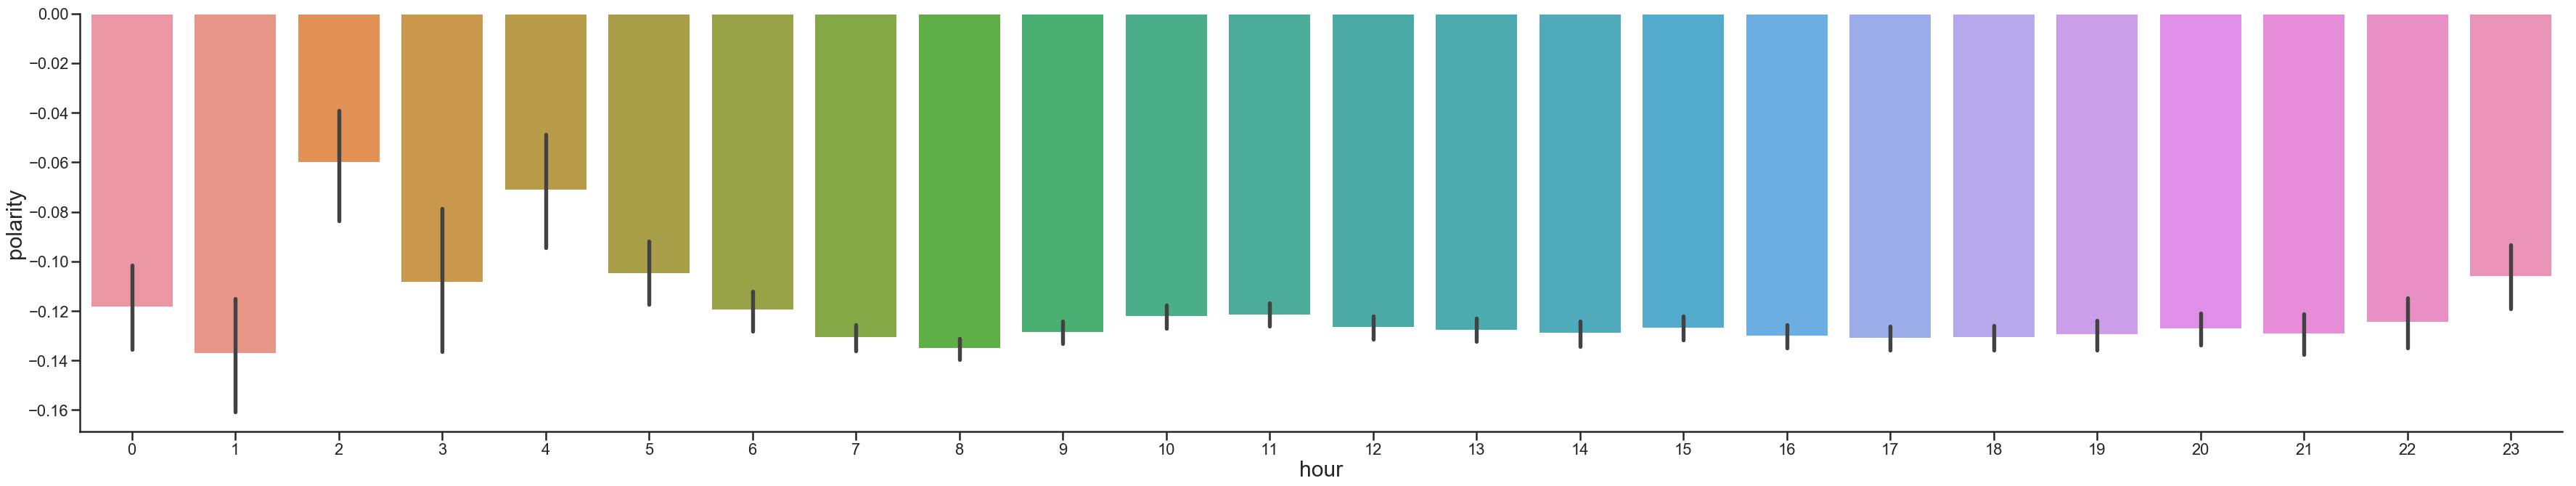

In [80]:
sns.catplot(x='hour', y='polarity', data=data_filtered, kind='bar', height=10, aspect=5)

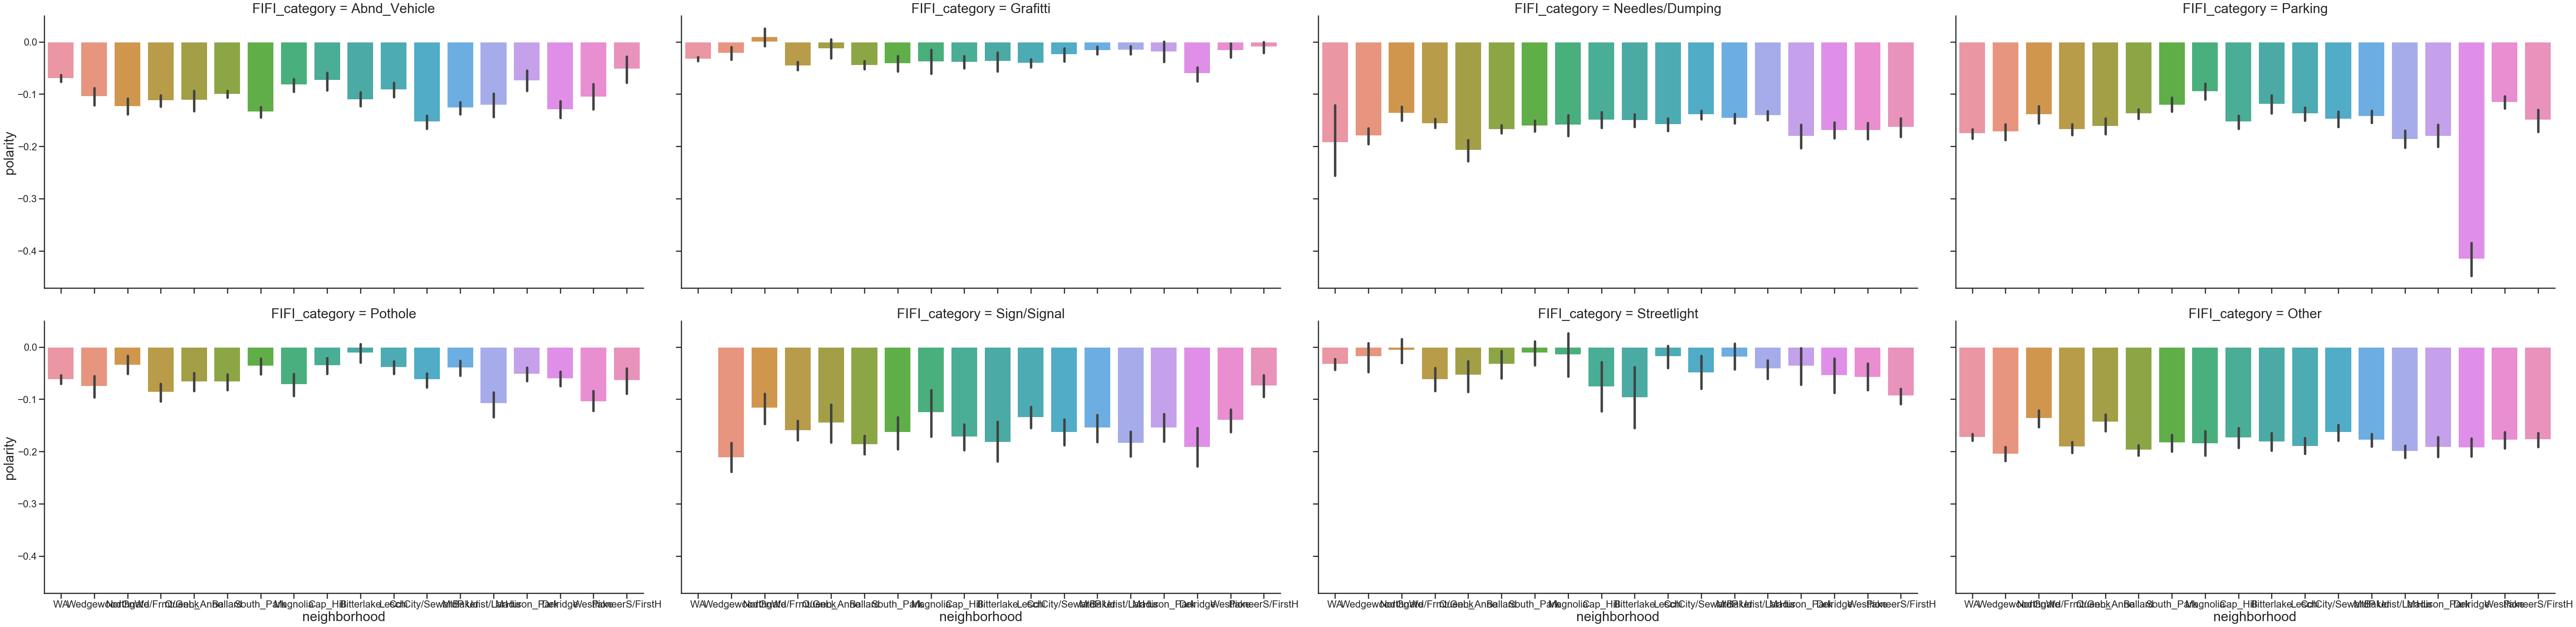

In [81]:
sns.catplot(x='neighborhood', y='polarity', data=data_filtered, kind='bar', col='FIFI_category', col_wrap=4, height=10, aspect=2)

### POS analysis

In [11]:
data_filtered.head(1)

Service_Request_Number        Created_Date                         Location                                   Location_Details      Description License_Number State Vehicle_Make Vehicle_Color  Time_parked Photo FIFI_category Location_Details.1 Property_damage? Current_Issue Type_of_animal On_private_property? Graffiti_location Location_and_Description Obscene/Racial/Hateful? Street/Intersection Where? Type_of_item? Veg_location Vegetation_Safety_Issue Parking_Violation_Concerning License_Plate_Number Location_details  7_digit_number_on_pole Issue        date  year  month  day day_of_week  hour                                          date_bin zip neighborhood      entry_clean            desc_nltk                                    POS
0            13-00036779 2013-05-09 20:32:33  5208 BEACON AVE S, SEATTLE, WA   5200 Beacon Ave S Seattle, WA 98108; XY: 12775...  Ford light blue        AHZ9829   NaN         Ford          Blue  Over 3 Days   NaN  Abnd_Vehicle                NaN              NaN           NaN            NaN                  NaN               NaN                      NaN                     NaN                 NaN    NaN           NaN          NaN                     NaN                          NaN                  NaN              NaN                     NaN   NaN  2013-05-09  2013      5    9    Thursday    20  (1.3680047394092564e+18, 1.3729967948195128e+18]  WA           WA  ford light blue  [ford, light, blue]  [(ford, NN), (light, NN), (blue, NN)]

In [24]:
#use groupby and sum to get a combined list containing POS tagging data
pos_FIFIcat_groupby = data_filtered.groupby(['FIFI_category', 'neighborhood'])['POS'].sum().reset_index(name='POS')
#use counter to count POS for each groupby category 
pos_FIFIcat_groupby['POS_count'] = [Counter(tag for word, tag in row) for row in pos_FIFIcat_groupby['POS']]
pos_FIFIcat_groupby.head(1)

FIFI_category neighborhood                                                POS                                          POS_count
0  Abnd_Vehicle      Ballard  [(larg, NN), (southwind, NN), (brand, NN), (rv...  {'NN': 20507, 'JJ': 6184, 'IN': 605, 'VBD': 47...

Abnd_Vehicle_Ballard


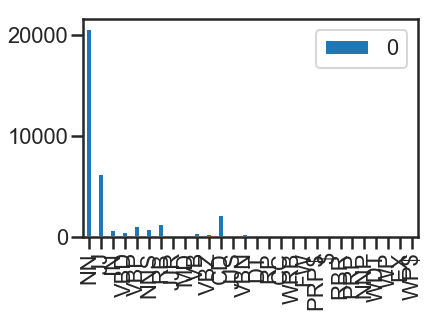

Abnd_Vehicle_Bitterlake


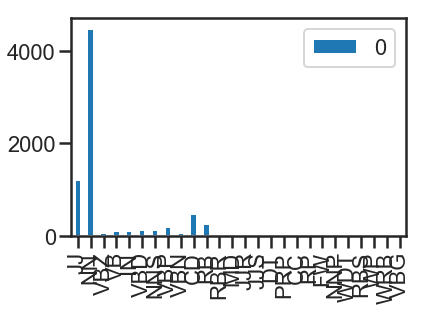

Abnd_Vehicle_Cap_Hill


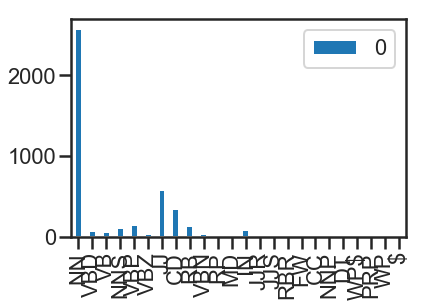

Abnd_Vehicle_ColCity/SewardP


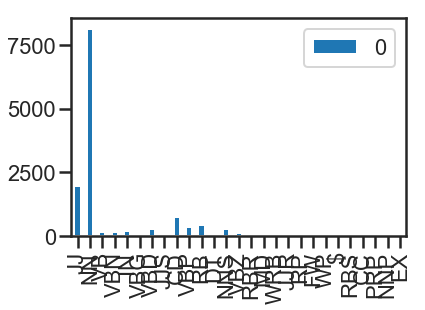

Abnd_Vehicle_Delridge


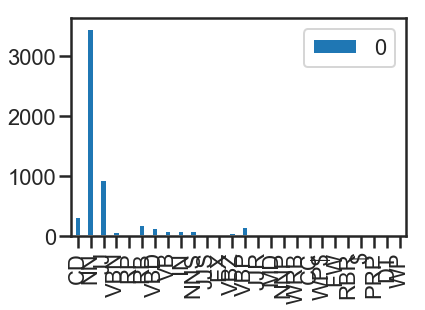

Abnd_Vehicle_GnWd/Frmt/GnLk


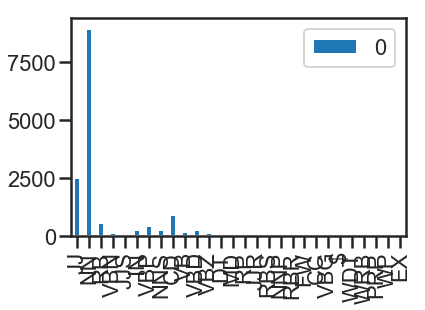

Abnd_Vehicle_Leschi


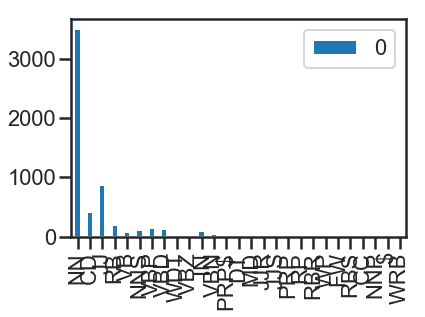

Abnd_Vehicle_Madison_Park


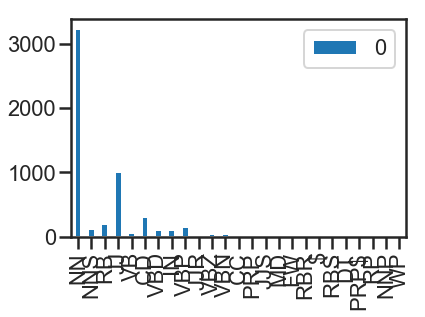

Abnd_Vehicle_Magnolia


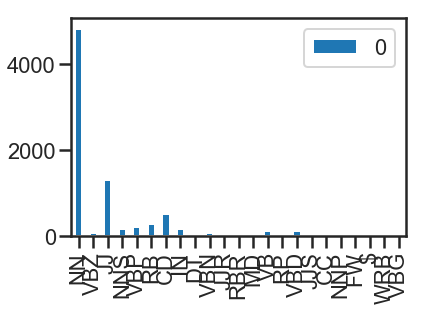

Abnd_Vehicle_MtBaker


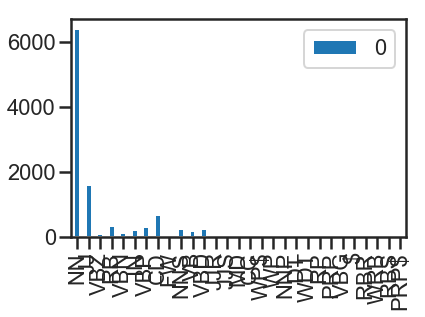

Abnd_Vehicle_Northgate


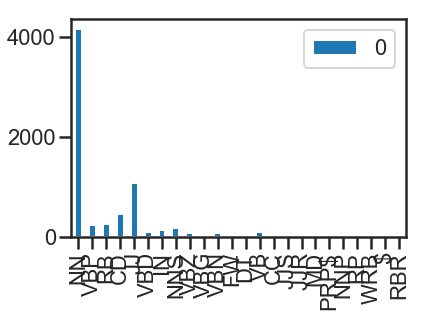

Abnd_Vehicle_PioneerS/FirstH


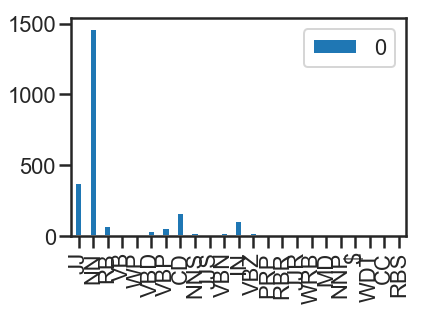

Abnd_Vehicle_Queen_Anne


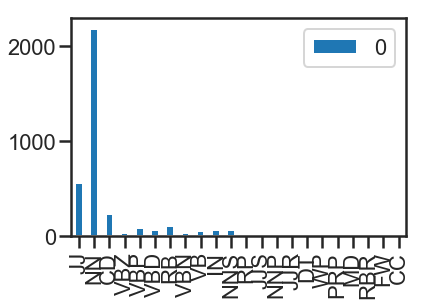

Abnd_Vehicle_South_Park


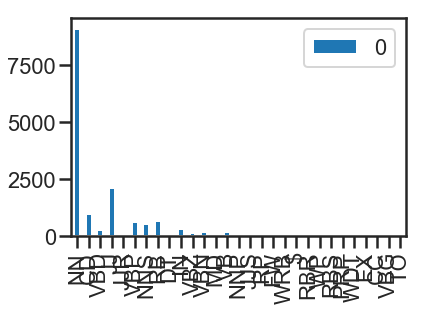

Abnd_Vehicle_Udist/LarHur


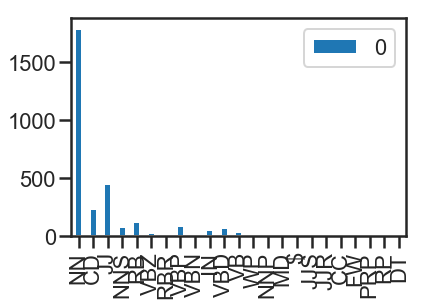

Abnd_Vehicle_WA


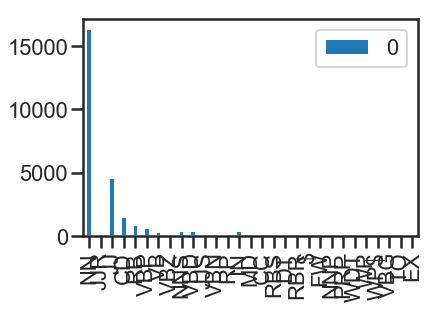

Abnd_Vehicle_Wedgewood


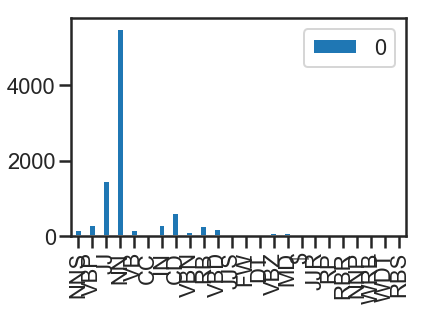

Abnd_Vehicle_Westlake


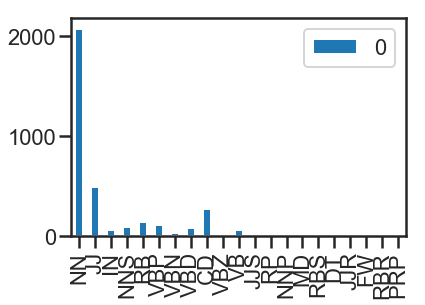

Grafitti_Ballard


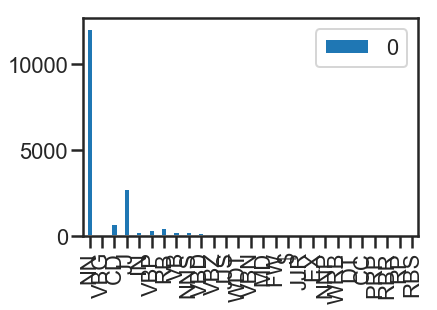

Grafitti_Bitterlake


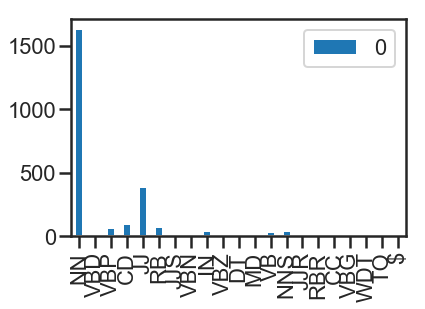

Grafitti_Cap_Hill


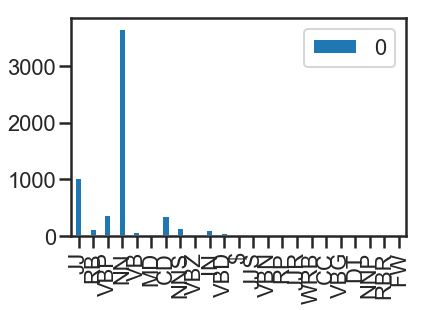

Grafitti_ColCity/SewardP


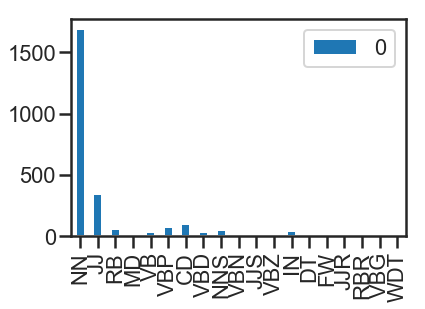

Grafitti_Delridge


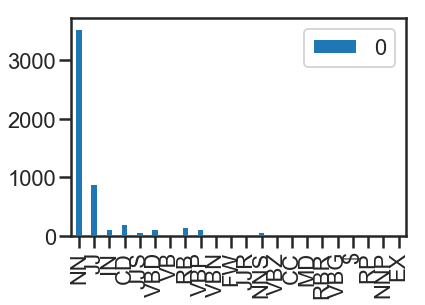

Grafitti_GnWd/Frmt/GnLk


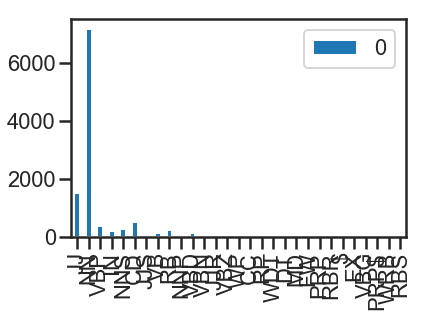

Grafitti_Leschi


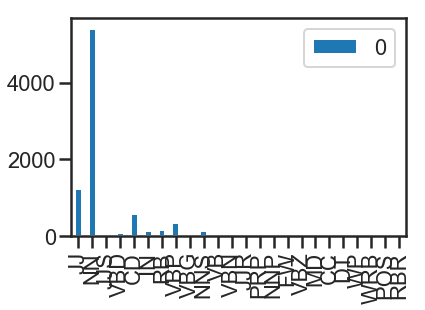

Grafitti_Madison_Park


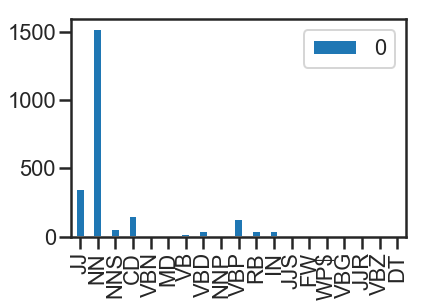

Grafitti_Magnolia


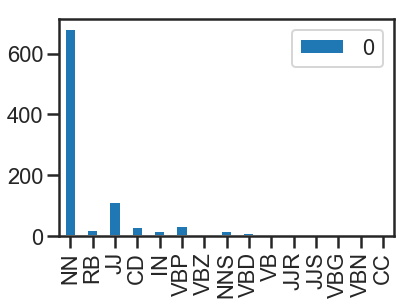

Grafitti_MtBaker


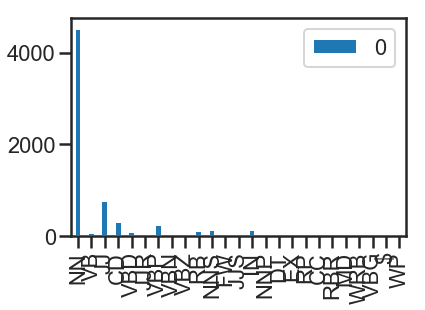

Grafitti_Northgate


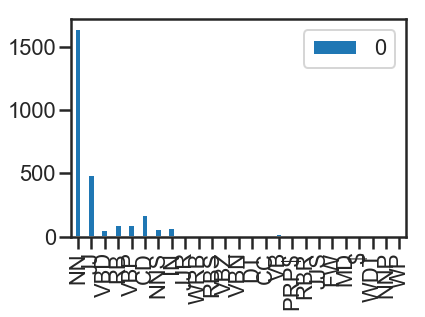

Grafitti_PioneerS/FirstH


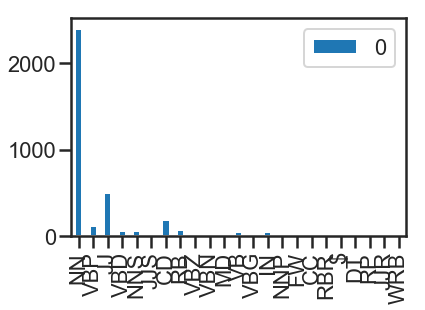

Grafitti_Queen_Anne


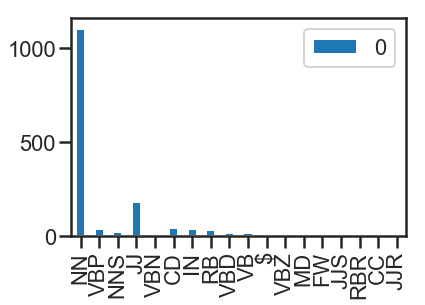

Grafitti_South_Park


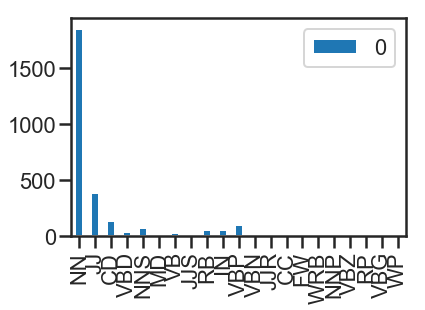

Grafitti_Udist/LarHur


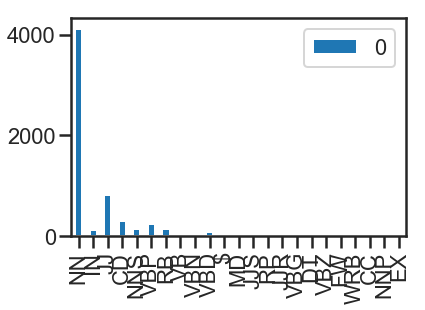

Grafitti_WA


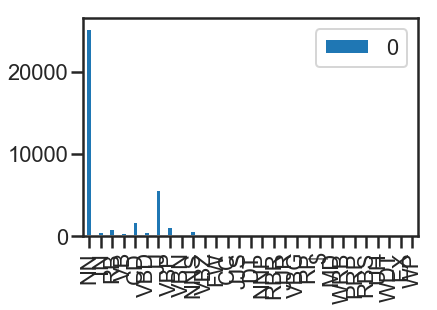

Grafitti_Wedgewood


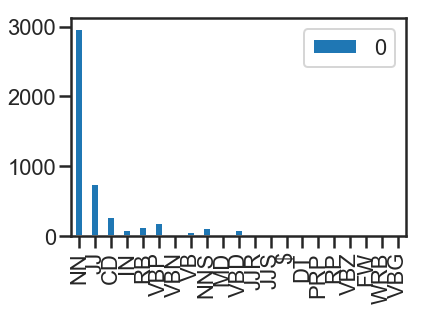

Grafitti_Westlake


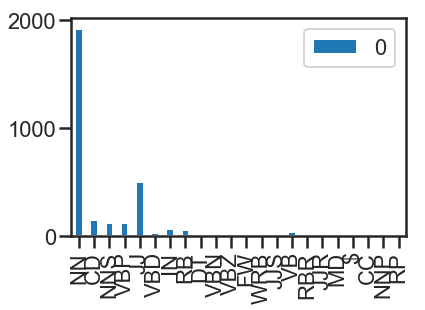

Needles/Dumping_Ballard


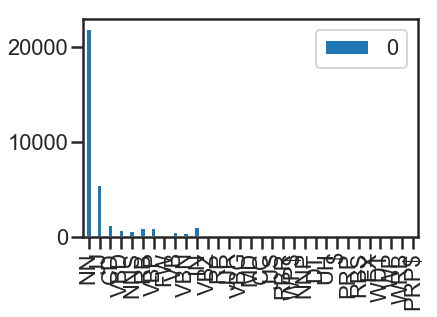

Needles/Dumping_Bitterlake


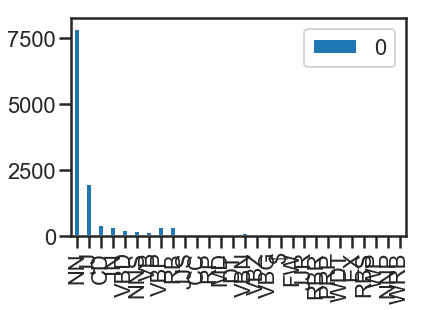

Needles/Dumping_Cap_Hill


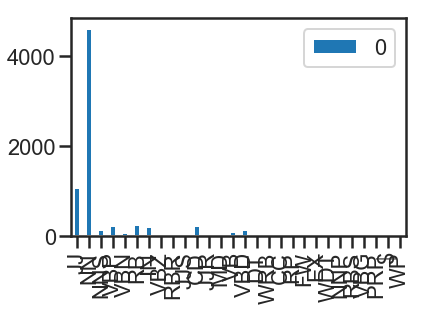

Needles/Dumping_ColCity/SewardP


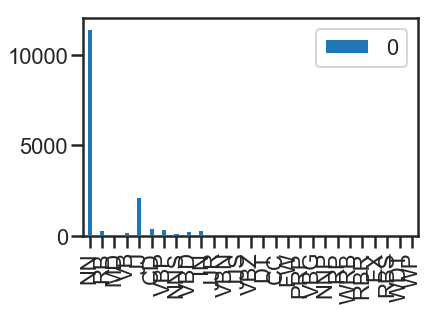

Needles/Dumping_Delridge


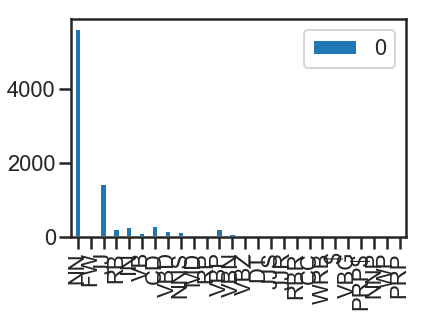

Needles/Dumping_GnWd/Frmt/GnLk


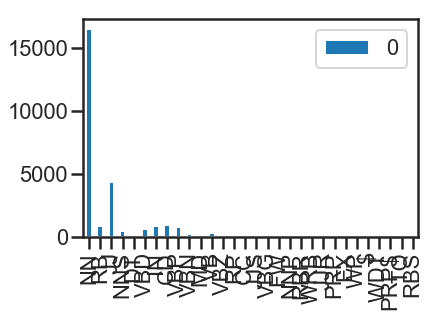

Needles/Dumping_Leschi


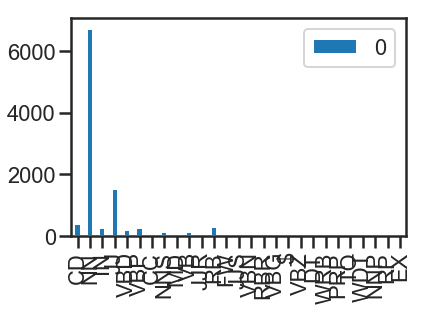

Needles/Dumping_Madison_Park


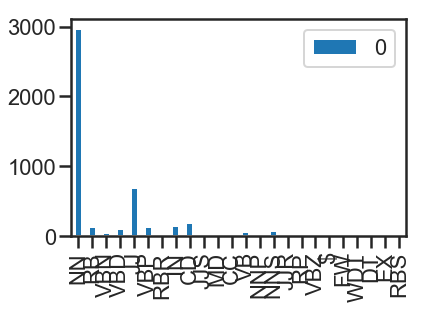

Needles/Dumping_Magnolia


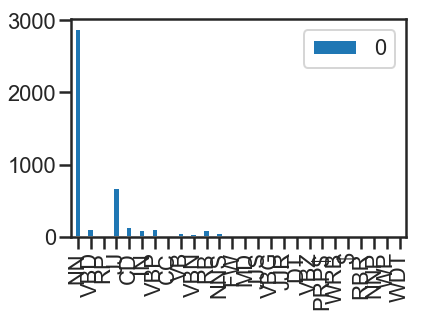

Needles/Dumping_MtBaker


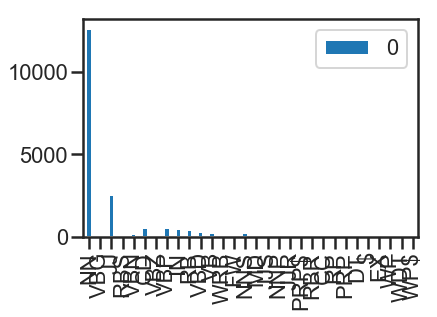

Needles/Dumping_Northgate


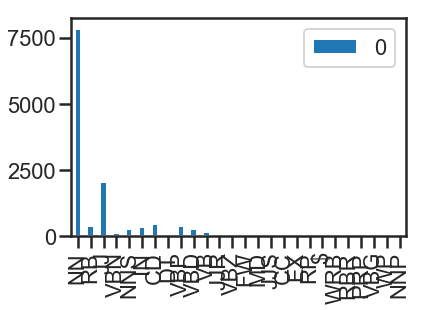

Needles/Dumping_PioneerS/FirstH


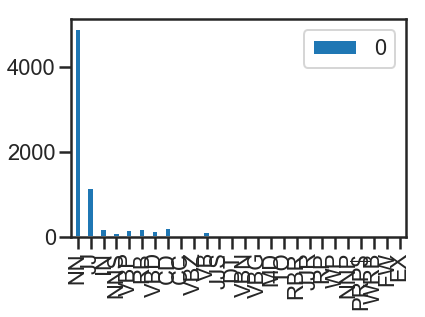

Needles/Dumping_Queen_Anne


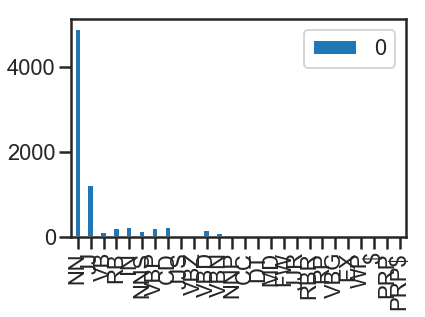

Needles/Dumping_South_Park


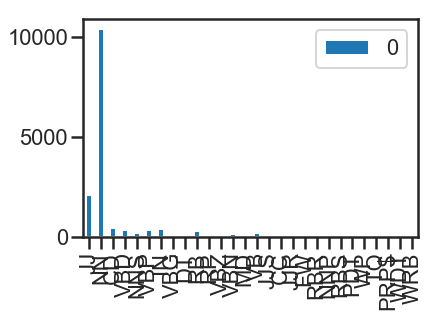

Needles/Dumping_Udist/LarHur


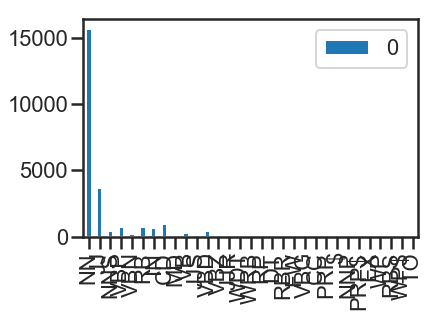

Needles/Dumping_WA


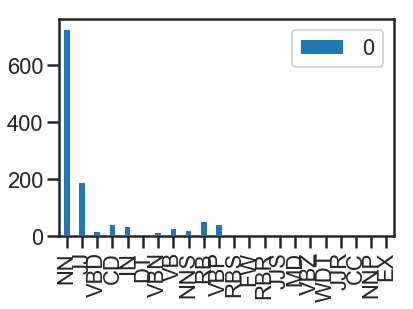

Needles/Dumping_Wedgewood


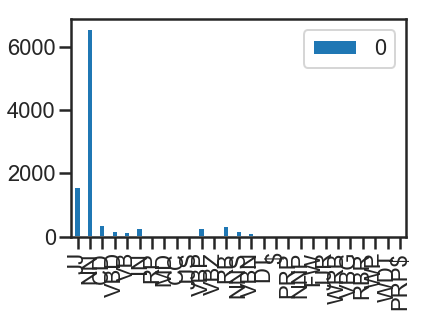

Needles/Dumping_Westlake


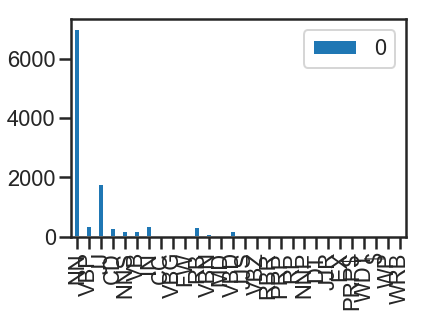

Other_Ballard


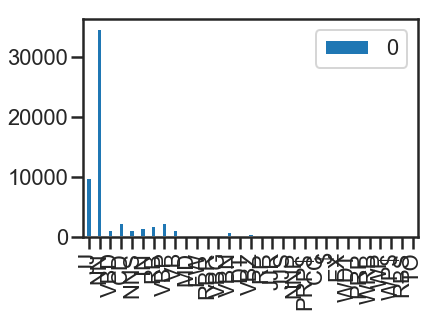

Other_Bitterlake


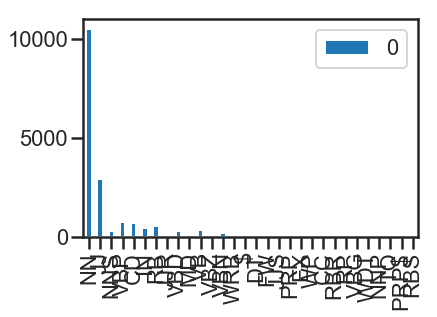

Other_Cap_Hill


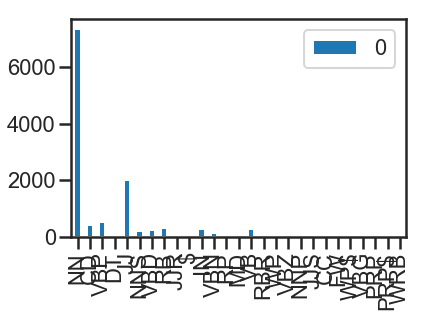

Other_ColCity/SewardP


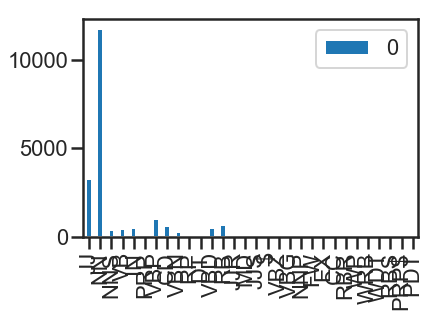

Other_Delridge


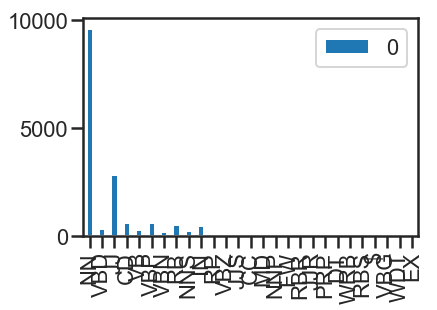

Other_GnWd/Frmt/GnLk


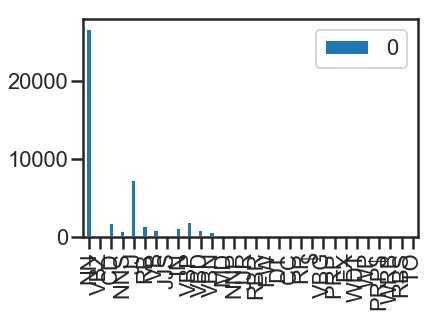

Other_Leschi


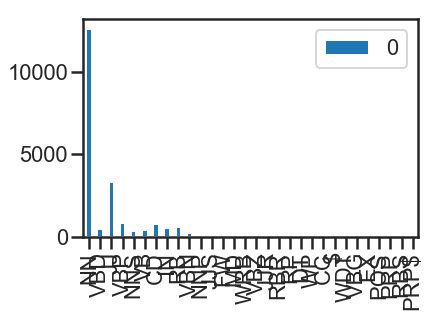

Other_Madison_Park


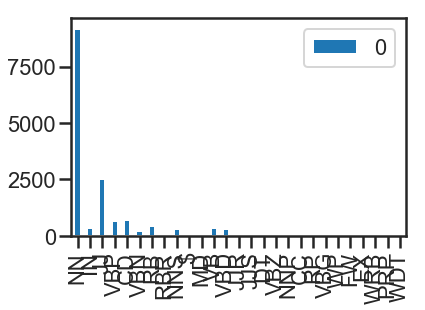

Other_Magnolia


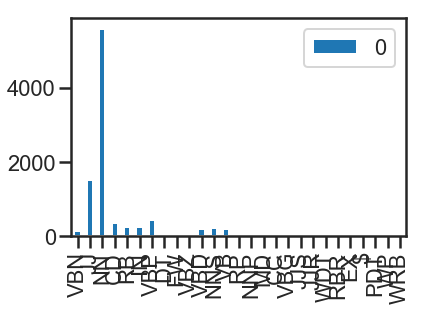

Other_MtBaker


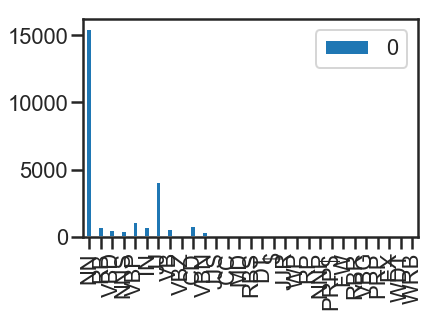

Other_Northgate


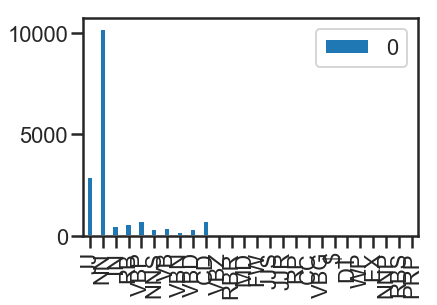

Other_PioneerS/FirstH


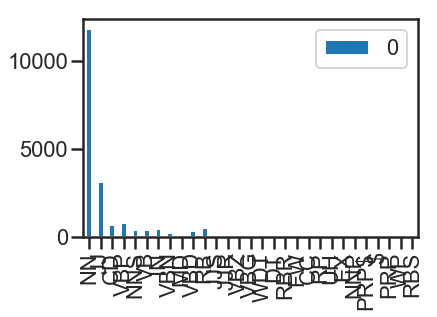

Other_Queen_Anne


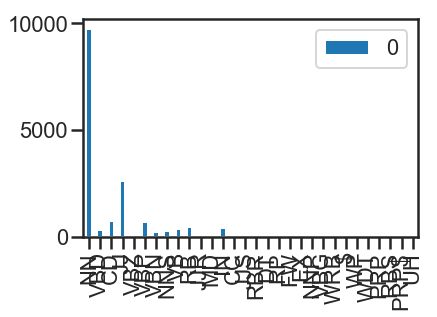

Other_South_Park


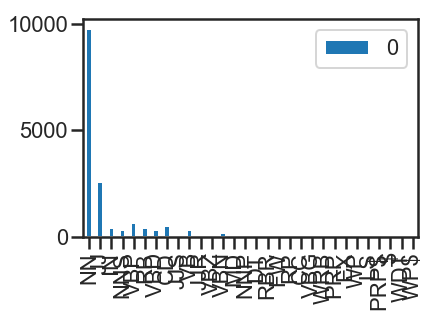

Other_Udist/LarHur


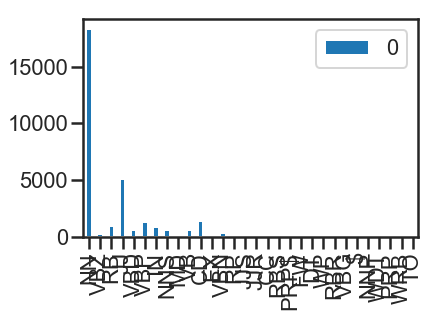

Other_WA


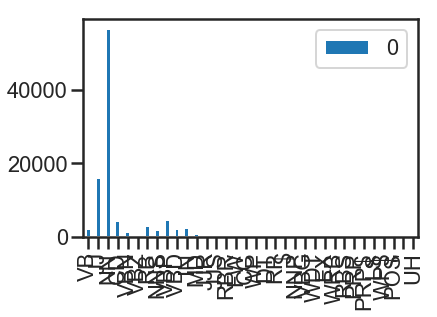

Other_Wedgewood


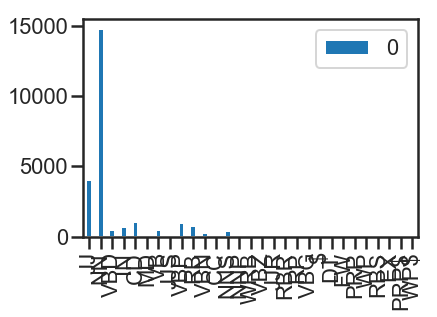

Other_Westlake


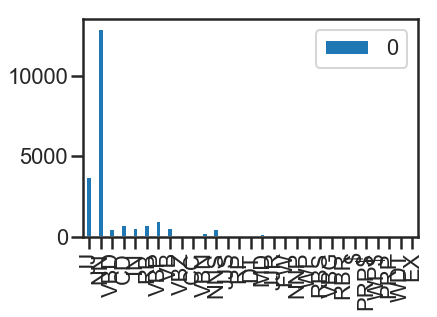

Parking_Ballard


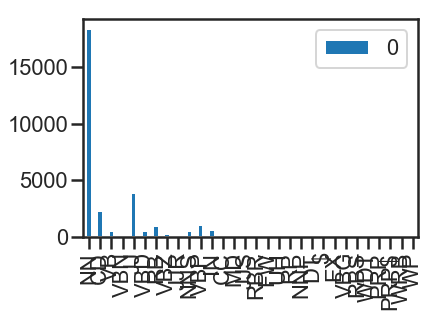

Parking_Bitterlake


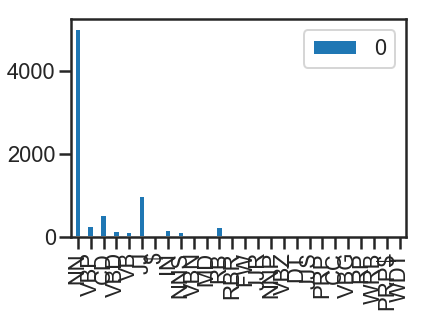

Parking_Cap_Hill


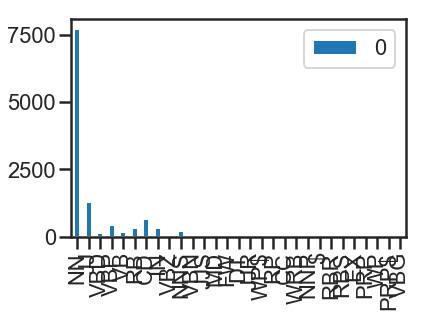

Parking_ColCity/SewardP


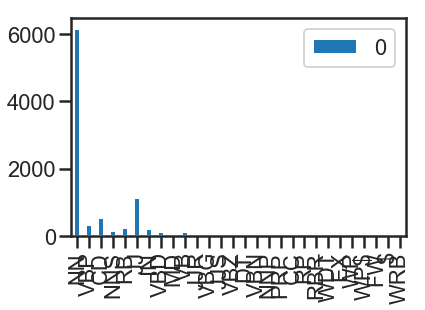

Parking_Delridge


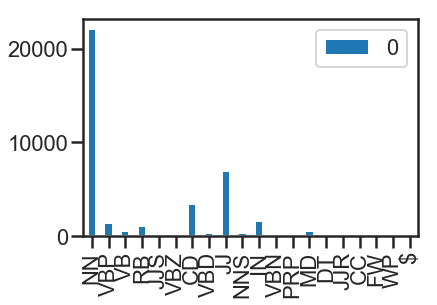

Parking_GnWd/Frmt/GnLk


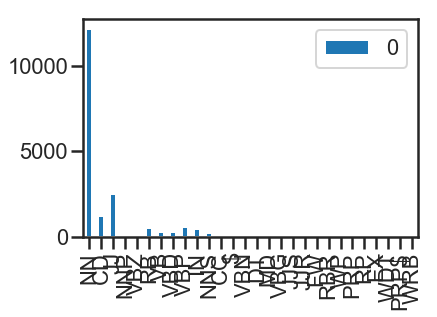

Parking_Leschi


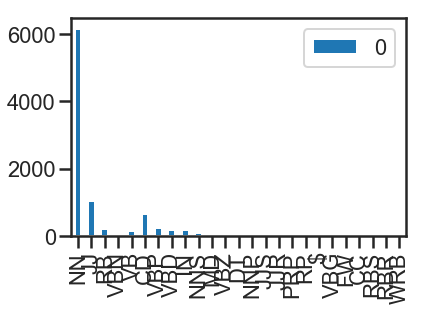

Parking_Madison_Park


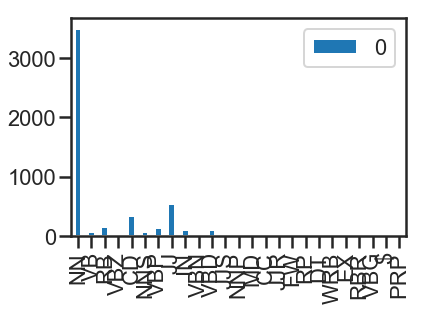

Parking_Magnolia


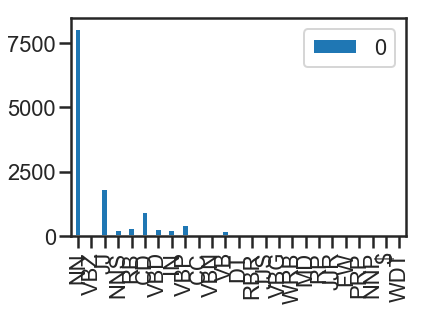

Parking_MtBaker


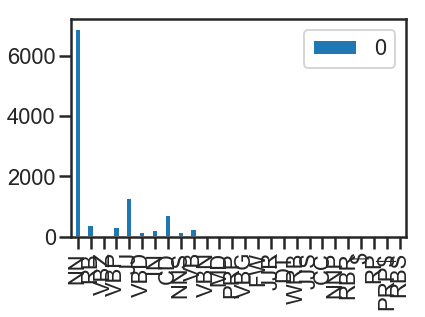

Parking_Northgate


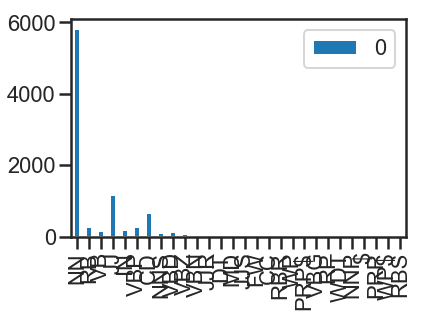

Parking_PioneerS/FirstH


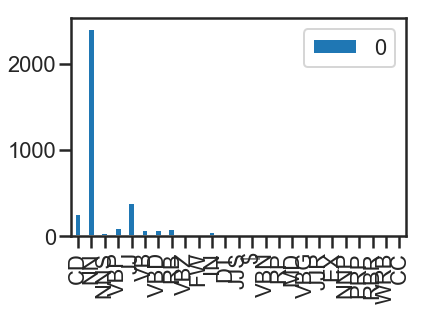

Parking_Queen_Anne


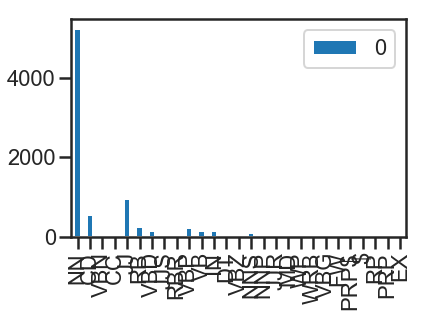

Parking_South_Park


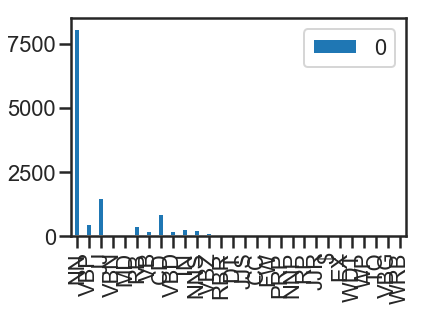

Parking_Udist/LarHur


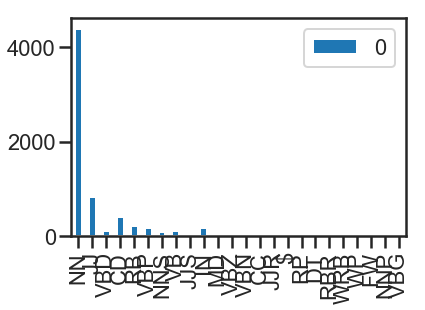

Parking_WA


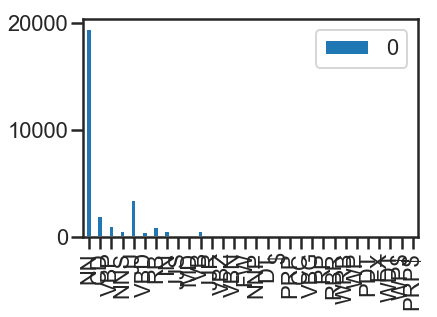

Parking_Wedgewood


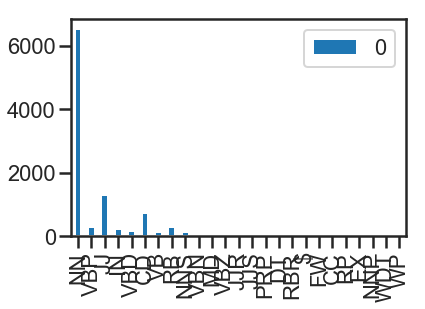

Parking_Westlake


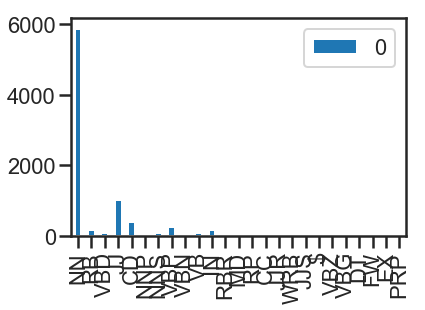

Pothole_Ballard


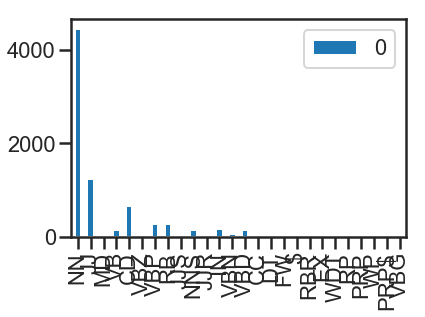

Pothole_Bitterlake


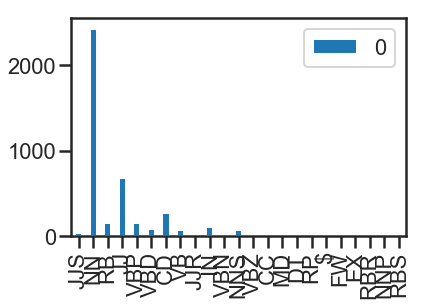

Pothole_Cap_Hill


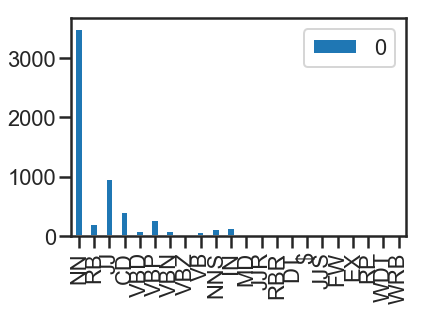

Pothole_ColCity/SewardP


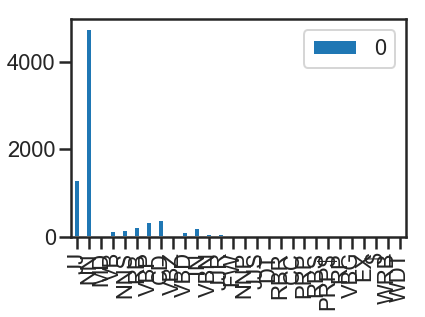

Pothole_Delridge


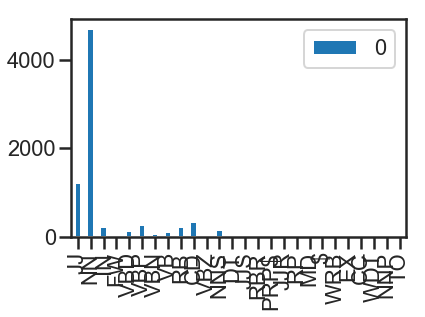

Pothole_GnWd/Frmt/GnLk


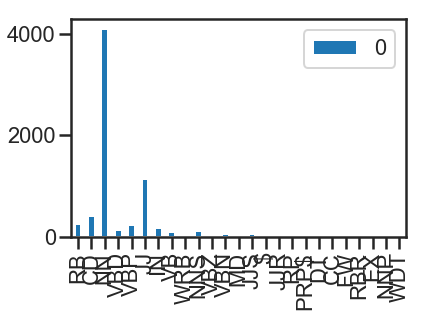

Pothole_Leschi


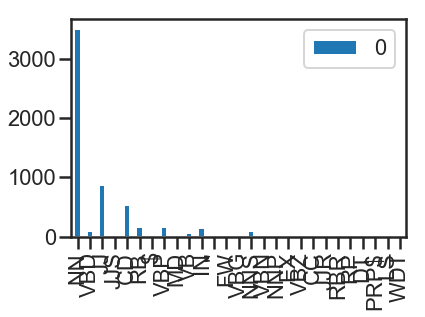

Pothole_Madison_Park


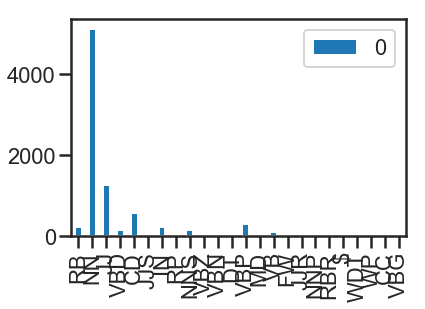

Pothole_Magnolia


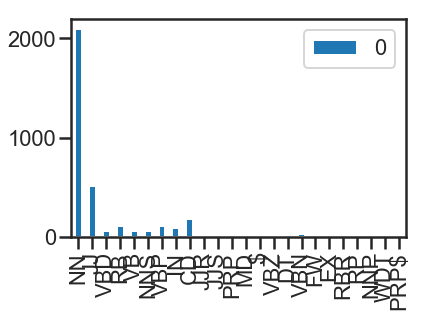

Pothole_MtBaker


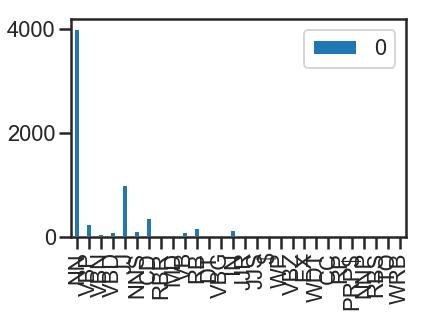

Pothole_Northgate


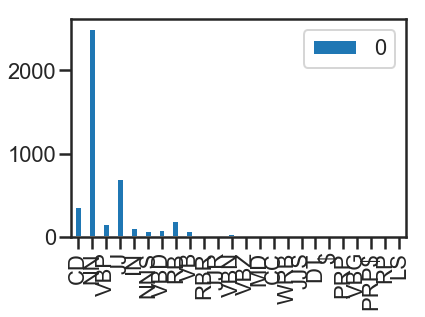

Pothole_PioneerS/FirstH


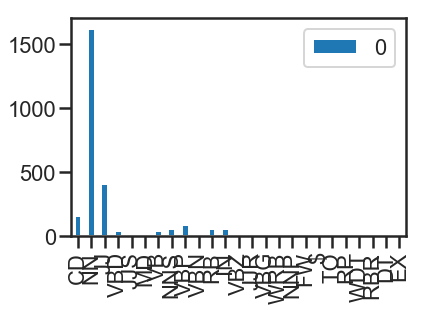

Pothole_Queen_Anne


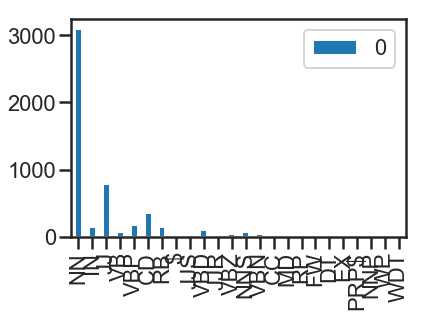

Pothole_South_Park


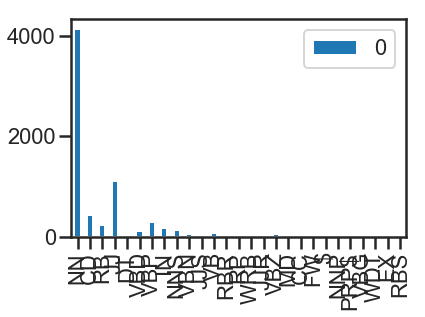

Pothole_Udist/LarHur


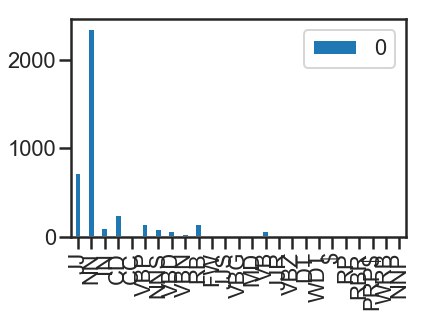

Pothole_WA


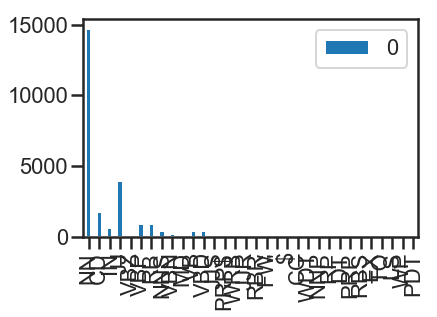

Pothole_Wedgewood


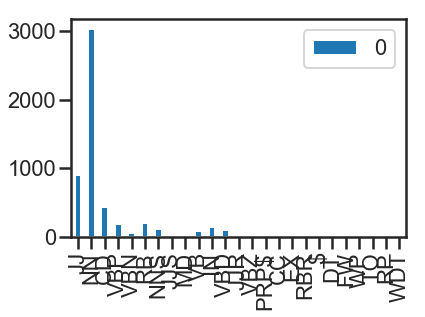

Pothole_Westlake


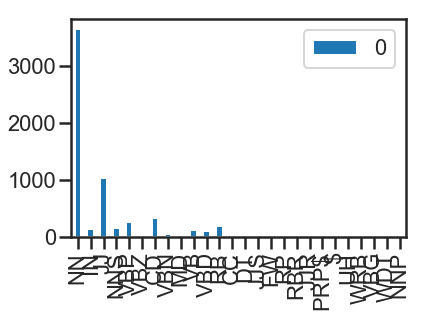

Sign/Signal_Ballard


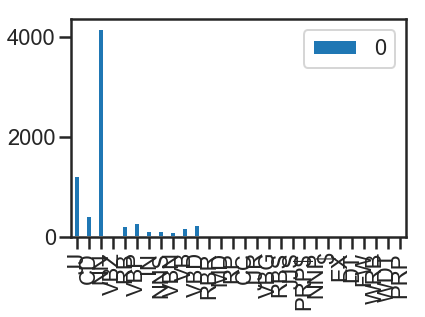

Sign/Signal_Bitterlake


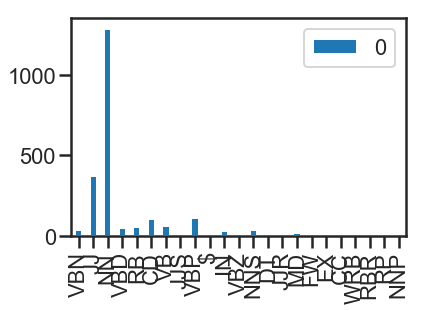

Sign/Signal_Cap_Hill


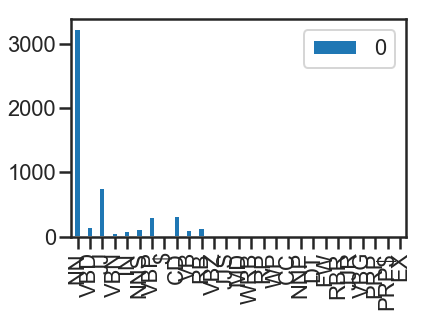

Sign/Signal_ColCity/SewardP


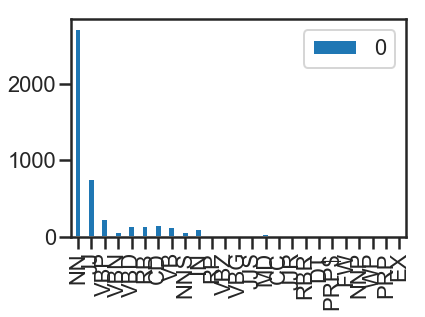

Sign/Signal_Delridge


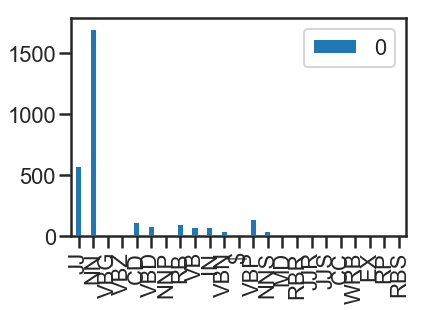

Sign/Signal_GnWd/Frmt/GnLk


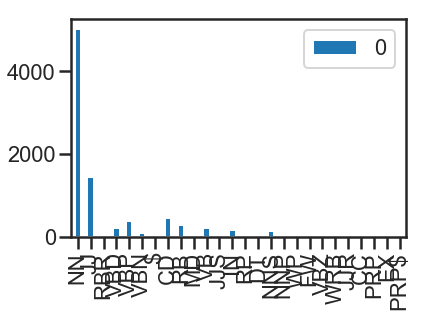

Sign/Signal_Leschi


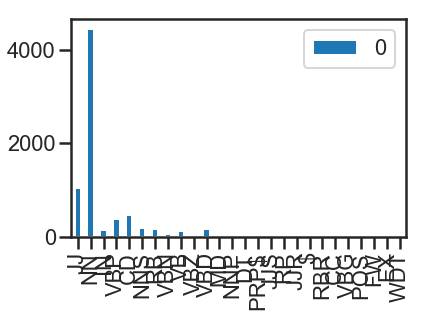

Sign/Signal_Madison_Park


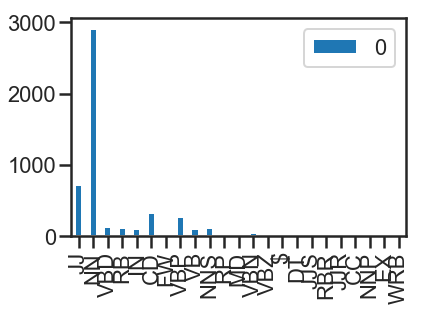

Sign/Signal_Magnolia


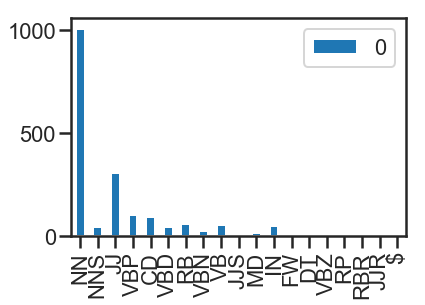

Sign/Signal_MtBaker


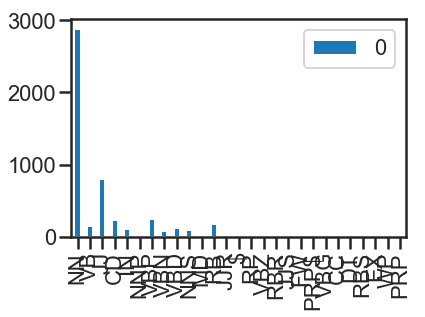

Sign/Signal_Northgate


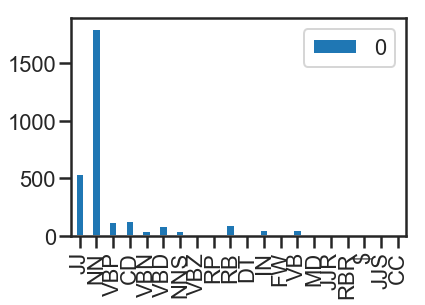

Sign/Signal_PioneerS/FirstH


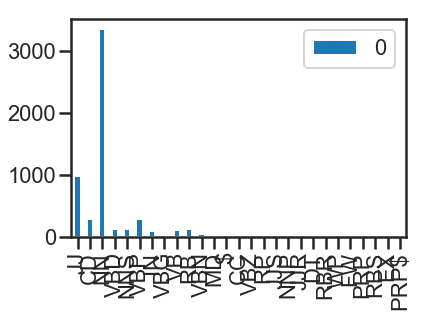

Sign/Signal_Queen_Anne


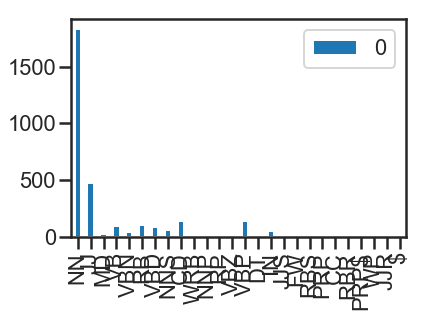

Sign/Signal_South_Park


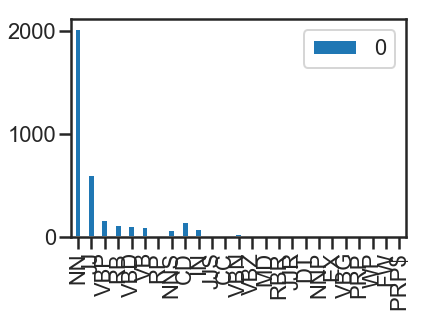

Sign/Signal_Udist/LarHur


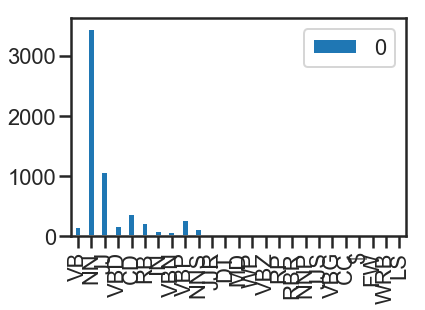

Sign/Signal_Wedgewood


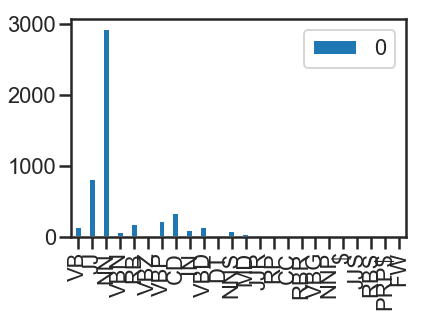

Sign/Signal_Westlake


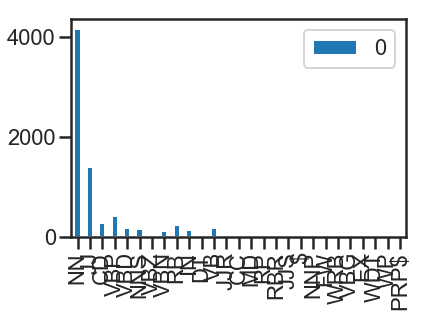

Streetlight_Ballard


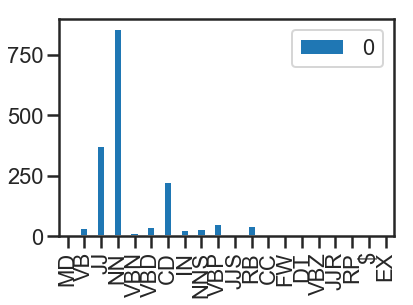

Streetlight_Bitterlake


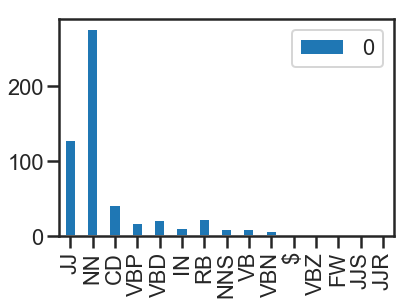

Streetlight_Cap_Hill


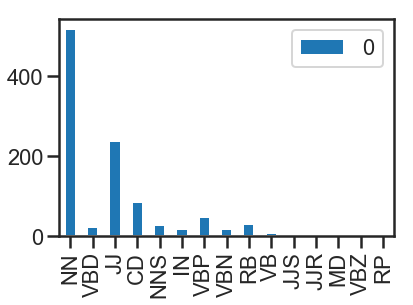

Streetlight_ColCity/SewardP


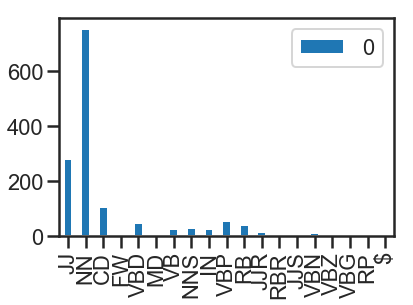

Streetlight_Delridge


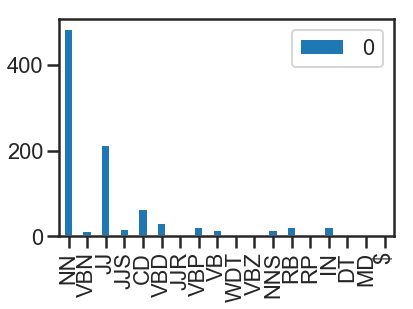

Streetlight_GnWd/Frmt/GnLk


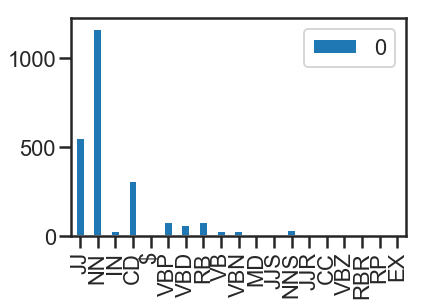

Streetlight_Leschi


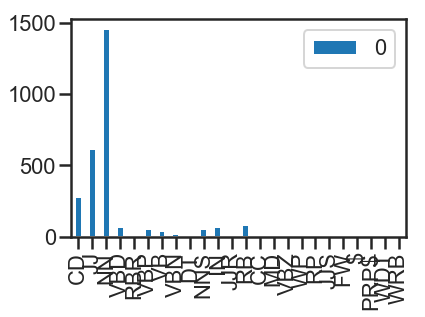

Streetlight_Madison_Park


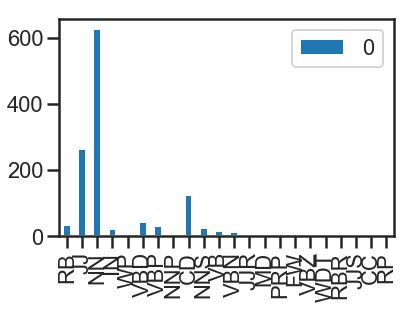

Streetlight_Magnolia


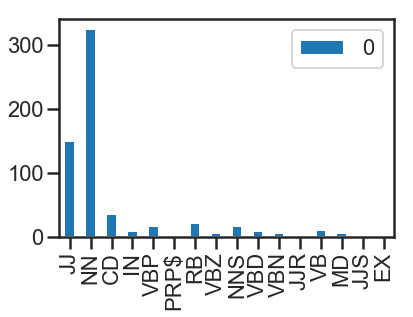

Streetlight_MtBaker


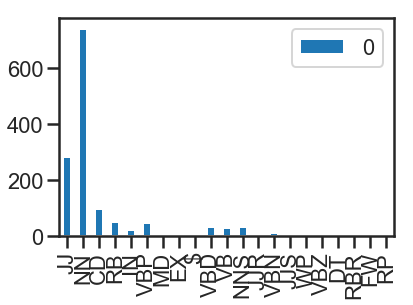

Streetlight_Northgate


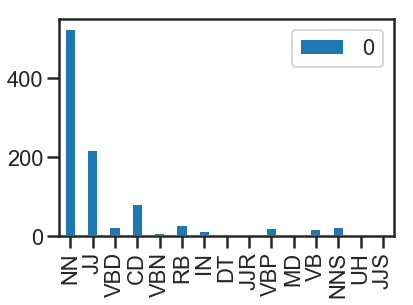

Streetlight_PioneerS/FirstH


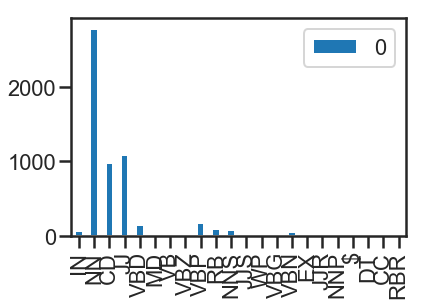

Streetlight_Queen_Anne


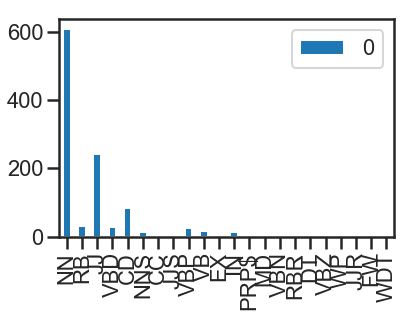

Streetlight_South_Park


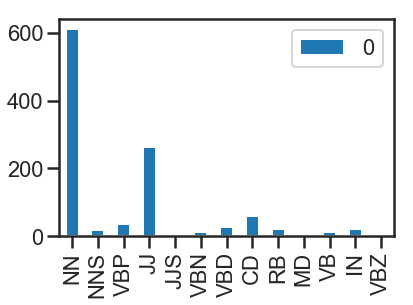

Streetlight_Udist/LarHur


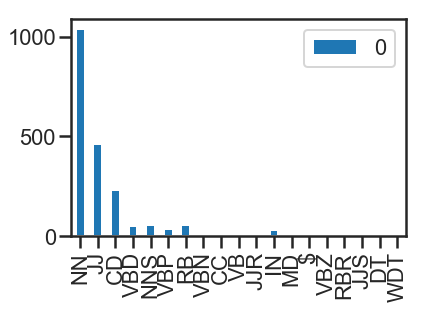

Streetlight_WA


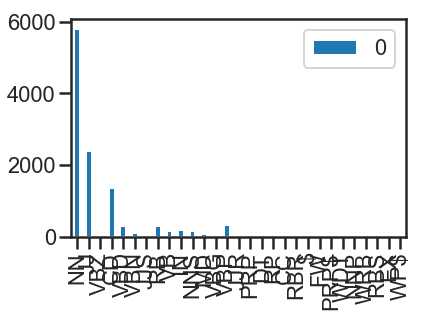

Streetlight_Wedgewood


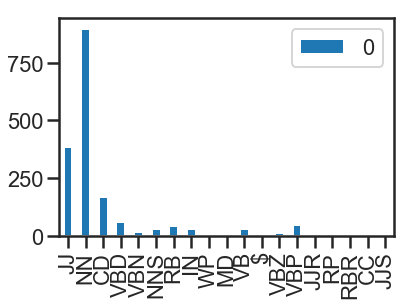

Streetlight_Westlake


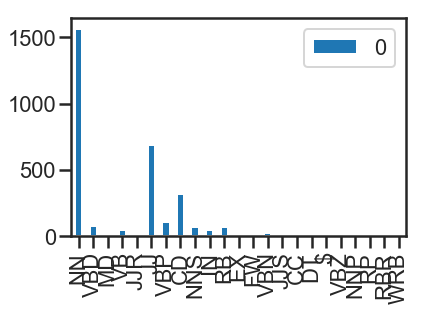

In [74]:
POS_counts_df = pd.DataFrame()
for index, row in pos_FIFIcat_groupby.iterrows():
    print(str(row['FIFI_category']+ '_' + row['neighborhood']))
    pd.DataFrame(data = list(row['POS_count'].values()), index=list(row['POS_count'])).plot(kind='bar')
    plt.show()
    


### Word frequency exploration

In [ ]:
zip_filtered_note.head(1)

In [ ]:
zip_filtered_groupby = zip_filtered_note.groupby(['FIFI_category'])['entry_clean'].sum(axis=1).reset_index(name='words_clean')
zip_filtered_groupby

In [ ]:
zip_filtered_groupby.head(1)
#len(zip_filtered_groupby.iloc[0]['words_clean'])

In [ ]:
fdist = FreqDist(zip_filtered_groupby.iloc[0]['words_clean'])
print(fdist)


### Topic modeling with LDA

In [ ]:
# Create dictionary
dictionary = corpora.Dictionary(zip_filtered_note['entry_clean'].values)
print(dictionary)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

#filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.1)

#create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in zip_filtered_note['entry_clean']]

document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print(bow_doc_x[i][0])
    print(dictionary[bow_doc_x[i][0]])
    print(bow_doc_x[i][1])
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

In [ ]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2, alpha = 0.001)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")